<h1 align="center" style="background-color:#616161;color:white">Next play prediction using Bayesian Inference</h1>

Here we shall apply Bayesian Inference, and specifically a Beta conjugate prior, to determine the liklihood of a user listening
to music in a given time slot.

<h4>Methodology</h4>
* $\theta$ is the probability of someone listening to music in a given Timeslot. This is what we wish to determine.
* Our prior beliefs will be based on analyzing the entire population, and our posterior belief will be to take into account a users personal play history up to the cut-off point for the training data

$p(\theta_{jt} | Y_{jt}) = Beta(\alpha_{jt} + Y_{jt}, \beta_{jt} + N_{jt}-Y_{jt})$ 
for user j, at time slot $t$

* Note: How we determine the prior probability is based on analyzing how many times users played music in that time slot out of the total number of chances they had to listen to music in that time slot. This latter amount has to be estimated from the data in a somewhat crude manner (count up the total number of weeks they listened to music in ANY timeslot ).

<h3 style="background-color:#616161;color:white">0. Setup</h3>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Input Parameters</div>

In [1]:
# Train / Test split
newUsers = 10   # Num of randomly selected users to separate out of eval 2

# Root path
#root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
root = "/home/badrul/git/EventPrediction" # BA, Linux

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Import Libraries</div>

In [2]:
# Core
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer    # Used for debugging
import logging

# File and database management
import csv
import os
import sys
import json
import sqlite3
from pathlib import Path

# Date/Time
import datetime
import time
from datetime import timedelta
# Recommend switching to: http://arrow.readthedocs.io/en/latest/

# Visualization
from ggplot import *                        # Preferred
import matplotlib.pyplot as plt             # Quick
%matplotlib inline

# Data science (comment out if not needed)
#from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc

# Misc
import random

#-------------- Custom Libs -----------------#
os.chdir(root)

# Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

# Custom Libs
import coreCode as cc
import lastfmCode as fm

/usr/local/lib/python3.5/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.5/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Declare Functions</div>

In [3]:
# Function definition

def estBetaParams(mu, var):
    a = ((1 - mu) / var - 1 / mu) * mu**2
    b = a * (1 / mu - 1)
    return (a,b)

def getNextPlayProb_Beta(df,Timeslot):
    # Calculate posteriors: a=a+y and b=b+n-y
    playCount = df[df.Timeslot == Timeslot]['PlayCount'].sum()
    # Count num of weeks up to this point
    totalWks = len(df.PlayDate.dt.week.unique())
    a = priorDf.loc[Timeslot]['a'] + playCount
    b = priorDf.loc[Timeslot]['b'] + totalWks-playCount
    #Tracer()()
    mu = a/(a+b)
    #print(playCount,totalWks,a,b,mu)
    return mu

def toTimeSlot(dt, periodInterval):
    return str(int(dt.strftime('%w'))+1) +dt.strftime('-%H-') + str(int((int(dt.strftime('%M'))/periodInterval+1)))

def CalcProb(df):
    df.reset_index(inplace=True, drop=True)  # Important that this line is run every time the rest of it is run
    
    for i in range (0,df.shape[0]):       # let i go through 1 to length
        timeslot = df.iloc[i]['Timeslot']  
        userID = df.iloc[i]['UserID']
        df2=df.iloc[0:i][df.UserID == userID]          # Extract just rows up to point i for this user
        res = getNextPlayProb_Beta(df2,timeslot)   # Filter for the specific user and pass to function
        df.loc[(i),'EstProb'] = res
    return df

def evaluateThreshold(df, thresholds):
    l=len(thresholds)
    userID = str(df.iloc[0].UserID)
    res=np.matrix( [[userID]*l, thresholds, [0]*l] ).reshape(3,l).T
    i=0
    
    for t in thresholds:
        correctPos = df[(df.EstProb >= t) & (df.PlayCount>0)]['PlayCount'].count()
        correctNeg = df[(df.EstProb < t) & (df.PlayCount==0)]['PlayCount'].count()
        totalRows = len(df)
        percent = (correctPos+correctNeg)/totalRows
        #print("Threshold: {}. Total correct(Play): {} Total correct(NoPlay): {} Total Rows:{}  %: {}".format(t,correctPos,correctNeg,totalRows,percent))
        res[i,2] = percent
        i+=1
    res=pd.DataFrame(res,columns=['UserID','Threshold','Perc. Correct'])
    res[['Threshold','Perc. Correct']] = res[['Threshold','Perc. Correct']].apply(pd.to_numeric)
    return res

def getTrainAndTestData():
    con = sqlite3.connect(dbPath)
    c = con.cursor()

    # Get list of UserIDs 
    users = pd.read_sql_query("Select UserID from tblUsers Where tblUsers.TestUser = 0",con)

    fieldList="t, UserID, HrsFrom6pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t1,t2,t3,t4,t5,t10,t12hrs,t24hrs,t1wk,t2wks,t3wks,t4wks"
    trainDf=pd.DataFrame(columns=[fieldList])  # Create an emmpty df
    testDf=pd.DataFrame(columns=[fieldList])  # Create an emmpty df
    periodsInAMonth=int(60/periodGranularity)*24*7*4

    totalRows=0
    
    for user in users.itertuples():
        # Get training dataset
        SqlStr="""
        SELECT UserID, PlayDate, Timeslot, sum(PlayedMusic) as PlayCount from tblMainAgg 
        where UserID = {} group by UserID, PlayDate, Timeslot """.format(user.userID)
    
        df = pd.read_sql_query(SqlStr, con)
        
        if (len(df)> periodsInAMonth*3):
            totalRows += len(df)

            # Cut-off 1
            k = random.randint(periodsInAMonth, len(df))  # Pick a random data point after  the first 100 plays
            #Tracer()()  -- for debugging purposes
            testDf = testDf.append(df.iloc[k:k+periodsInAMonth])[df.columns.tolist()]

            tmp = df.drop(df.index[k:k+periodsInAMonth])

            # Cut-off 2
            k = random.randint(periodsInAMonth, len(tmp))
            testDf = testDf.append(tmp.iloc[k:k+periodsInAMonth])[df.columns.tolist()]
            trainDf = trainDf.append(tmp.drop(tmp.index[k:k+periodsInAMonth]))[df.columns.tolist()]
        else:
            print('Skipping user {} as not enough periods ({})'.format(user.userID,len(df)))
            
    if len(trainDf)+len(testDf) == totalRows:
        print('Ok')
    else:
        print("Incorrect. Total Rows = {}. TestDf+TrainDf rows = {}+{}={}".format(totalRows,len(testDf),len(trainDf),len(testDf)+len(trainDf)))
    
    # Remove playdate from train data and aggregate up
    trainDf.drop('PlayDate', axis=1, inplace=True)
    trainDf["UserID"] =  trainDf["UserID"].astype(int)
    trainDf=trainDf.groupby(['UserID', 'Timeslot'],as_index=False).sum()
    
    testDf["PlayDate"] = pd.to_datetime(testDf["PlayDate"])
    testDf["UserID"] =  testDf["UserID"].astype(int)
    testDf.sort_values(['UserID','PlayDate'], inplace=True)
    return trainDf, testDf

def getHiddenTestUsers(firstNPerc=1.0):
    con = sqlite3.connect(dbPath)
    c = con.cursor()

    # Get list of UserIDs 
    users = pd.read_sql_query("Select UserID from tblUsers Where tblUsers.TestUser = 1",con)

    fieldList="t, UserID, HrsFrom6pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t1,t2,t3,t4,t5,t10,t12hrs,t24hrs,t1wk,t2wks,t3wks,t4wks"
    testDf=pd.DataFrame(columns=[fieldList])  # Create an emmpty df
    periodsInAMonth=int(60/periodGranularity)*24*7*4

    totalRows=0
    
    for user in users.itertuples():
        # Get training dataset
        SqlStr="""
        SELECT UserID, PlayDate, Timeslot, sum(PlayedMusic) as PlayCount from tblMainAgg 
        where UserID = {} group by UserID, PlayDate, Timeslot Order By PlayDate""".format(user.userID)
    
        df = pd.read_sql_query(SqlStr, con)
        df["PlayDate"] = pd.to_datetime(df["PlayDate"])
        df.sort_values(['PlayDate'])
        totalRows += len(df)
        # Caluclate period cutt-off
        cutoff = int(len(df)*firstNPerc)
        testDf = testDf.append(df.iloc[0:cutoff])[df.columns.tolist()]
 
    testDf["PlayDate"] = pd.to_datetime(testDf["PlayDate"])
    testDf["UserID"] =  testDf["UserID"].astype(int)
    testDf.sort_values(['UserID','PlayDate'], inplace=True)
    return testDf

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Load settings</div>

In [4]:
settingsDict =  cc.loadSettings()
dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']
periodGranularity = int(settingsDict['periodGranularity'])

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Other setup</div>
None

<h3 style="background-color:#616161;color:white">1. Get train & test data</h3>

In [5]:
trainDf,testDf = getTrainAndTestData()

con = sqlite3.connect(dbPath)
# Also fetch the total number of weeks each user has played music
sqlStr = "Select userID, count(DISTINCT (strftime('%W',PlayedTimestamp)||strftime('%Y',PlayedTimestamp))) as TotalWks from tblMain group by userID"
wks = pd.read_sql_query(sqlStr, con)
wks.set_index('UserID',inplace=True)
con.close()

Skipping user 42 as not enough periods (0)
Skipping user 43 as not enough periods (0)
Skipping user 44 as not enough periods (0)
Skipping user 45 as not enough periods (0)
Skipping user 46 as not enough periods (0)
Skipping user 47 as not enough periods (0)
Skipping user 48 as not enough periods (0)
Skipping user 49 as not enough periods (0)
Skipping user 50 as not enough periods (0)
Skipping user 51 as not enough periods (0)
Skipping user 52 as not enough periods (0)
Skipping user 53 as not enough periods (0)
Skipping user 54 as not enough periods (0)
Skipping user 55 as not enough periods (0)
Skipping user 56 as not enough periods (0)
Skipping user 57 as not enough periods (0)
Skipping user 58 as not enough periods (0)
Skipping user 59 as not enough periods (0)
Skipping user 60 as not enough periods (0)
Skipping user 61 as not enough periods (0)
Skipping user 62 as not enough periods (0)
Skipping user 63 as not enough periods (0)
Skipping user 64 as not enough periods (0)
Skipping us

Skipping user 233 as not enough periods (0)
Skipping user 234 as not enough periods (0)
Skipping user 235 as not enough periods (0)
Skipping user 236 as not enough periods (0)
Skipping user 237 as not enough periods (0)
Skipping user 238 as not enough periods (0)
Skipping user 239 as not enough periods (0)
Skipping user 240 as not enough periods (0)
Skipping user 241 as not enough periods (0)
Skipping user 242 as not enough periods (0)
Skipping user 243 as not enough periods (0)
Skipping user 244 as not enough periods (0)
Skipping user 245 as not enough periods (0)
Skipping user 246 as not enough periods (0)
Skipping user 247 as not enough periods (0)
Skipping user 248 as not enough periods (0)
Skipping user 249 as not enough periods (0)
Skipping user 250 as not enough periods (0)
Skipping user 251 as not enough periods (0)
Skipping user 252 as not enough periods (0)
Skipping user 253 as not enough periods (0)
Skipping user 254 as not enough periods (0)
Skipping user 255 as not enough 

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Preview Results</div>

In [6]:
trainDf.head()

,UserID,Timeslot,PlayCount
0,2,1-00-1,18.0
1,2,1-00-2,14.0
2,2,1-01-1,12.0
3,2,1-01-2,11.0
4,2,1-02-1,8.0


In [7]:
testDf.head()

,UserID,PlayDate,Timeslot,PlayCount
12881,2,2006-11-20,2-02-2,0.0
12882,2,2006-11-20,2-03-1,0.0
12883,2,2006-11-20,2-03-2,1.0
12884,2,2006-11-20,2-04-1,1.0
12885,2,2006-11-20,2-04-2,1.0


In [8]:
wks.head()

,TotalWks
UserID,
1,107
2,157
3,140
4,95
5,125


Note we are now capturing all song plays, and not just the start of a listening session so the pattern isn't as obvious as before

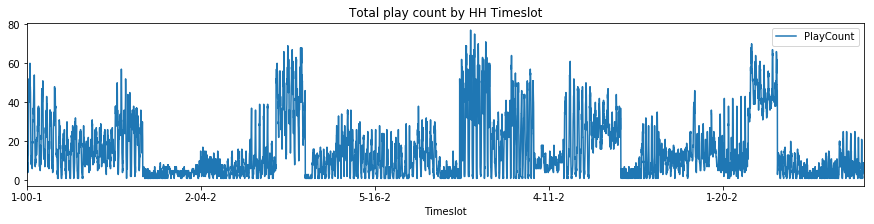

In [9]:
trainDf[trainDf.PlayCount >0].plot(x='Timeslot', y='PlayCount',figsize=[15,3],title='Total play count by HH Timeslot')

<h3 style="background-color:#616161;color:white">3. Construct prior probability from train data</h3>

Here we shall determine the alpa and beta parameters for a Beta distribution by calculating the probability of play in each timeslot, and then taking the mean and variance of this.

In [10]:
try:
    del trainDf['TotalWks']    # Delete col if it already exists
except KeyError:
    pass

# Calculate probability
trainDf=trainDf.set_index('UserID').join(wks)                      # Bring in total weeks from wks table
trainDf['Prob'] = trainDf['PlayCount'] / trainDf['TotalWks']      # Prob = num of plays in this period / total num of weeks
trainDf.reset_index(inplace=True)

# Calculate the Priors from trainDf. Note: We are taking the mean of the user means here
priorDf= trainDf.groupby('Timeslot')['Prob'].mean().to_frame('mean')  # Calculate the mean of prob for each period
priorDf['var'] = trainDf.groupby('Timeslot')['Prob'].var()           # Calculate the variance of prob for each period
a,b=estBetaParams(priorDf['mean'],priorDf['var'])                # Derive alpha & beta for the Beta dist
priorDf['a']= a                                                 # Store a and b back into priorDf
priorDf['b']= b

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Preview Results</div>

In [11]:
trainDf.head()

,UserID,Timeslot,PlayCount,TotalWks,Prob
0,2,1-00-1,18.0,157,0.114650
1,2,1-00-2,14.0,157,0.089172
2,2,1-01-1,12.0,157,0.076433
3,2,1-01-2,11.0,157,0.070064
4,2,1-02-1,8.0,157,0.050955


In [12]:
priorDf.head()

,mean,var,a,b
Timeslot,,,,
1-00-1,0.124909,0.010710,1.149928,8.056214
1-00-2,0.117152,0.011055,0.978901,7.376894
1-01-1,0.112819,0.011669,0.854907,6.722794
1-01-2,0.104922,0.010509,0.832743,7.104053
1-02-1,0.095845,0.009017,0.825298,7.785448


<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Additional Checks</div>

Let's do a few checks to make sure we've calculated the probability correctly.

Check that the min/max is within 0-1 boundaries

In [13]:
trainDf['Prob'].describe()

count    11088.000000
mean         0.117394
std          0.106369
min          0.000000
25%          0.028571
50%          0.094118
75%          0.188679
max          0.670588
Name: Prob, dtype: float64

Let's do a histogram to see what the distribution looks like

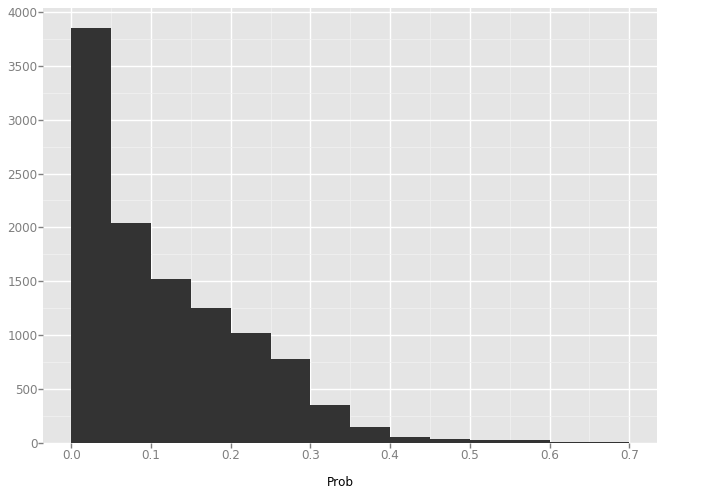

<ggplot: (-9223363244861868863)>

In [14]:
ggplot(aes(x='Prob'), data=trainDf) + \
    geom_histogram(binwidth=0.05)

The histogram above shows that most of the probabilities are very low which is as expected.

More crucially we can plot this distribution for a specific time-period.

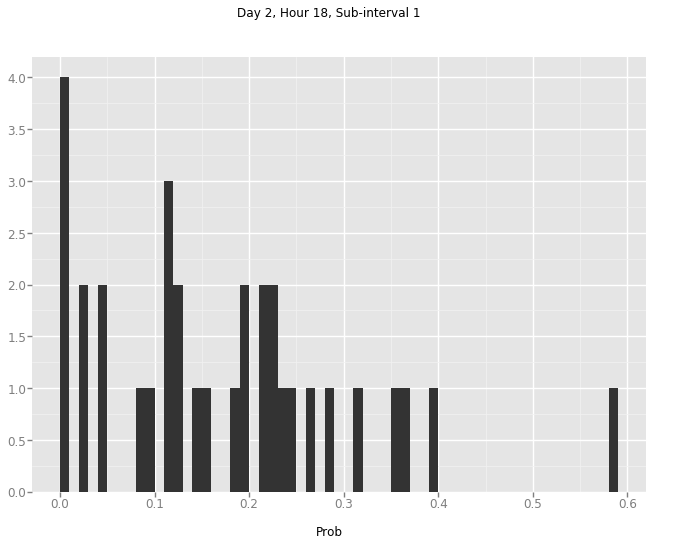

<ggplot: (8791995439459)>

In [15]:
Timeslot='2-18-1'
ggplot(aes(x='Prob'), data=trainDf[trainDf.Timeslot==Timeslot]) + \
    geom_histogram(binwidth=0.01) + ggtitle("Day {}, Hour {}, Sub-interval {}".format(Timeslot[0],Timeslot[2:4],Timeslot[5]))

Hour 18 (6pm) is one of the most popular times for listening to music. We see that for some users this probability is as high as 0.9. It is the mean and variance for each of these timeslot distributions that will be used to form a set of alpha and betas for our prior beta distribution model, as shown below.

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Plot of Beta distribution for specific timeslot</div>

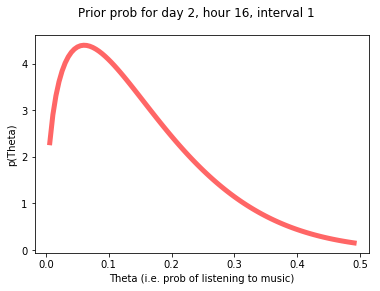

In [16]:
from scipy.stats import beta


p = '2-16-1'
a = priorDf.loc[p]['a']
b = priorDf.loc[p]['b']

# Plot our prior Beta PDF
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)  # Generate prob distribution
ax.set_xlabel('Theta (i.e. prob of listening to music)')
ax.set_ylabel('p(Theta)')

fig.suptitle('Prior prob for day {}, hour {}, interval {}'.format(p[0],p[2:4],p[5]))
ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6)

<h3 style="background-color:#616161;color:white">4. Test Set</h3>


In [17]:
# Calculate each users prob
testDf=CalcProb(testDf)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Preview results</div>

In [18]:
testDf[(testDf.Timeslot == '1-17-1')].head()

,UserID,PlayDate,Timeslot,PlayCount,EstProb
317,2,2006-11-26,1-17-1,0.0,0.149821
653,2,2006-12-03,1-17-1,0.0,0.132360
989,2,2006-12-10,1-17-1,0.0,0.118544
1325,2,2006-12-17,1-17-1,0.0,0.107339
1480,2,2008-08-10,1-17-1,1.0,0.090275


<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Plot some of the results</div>

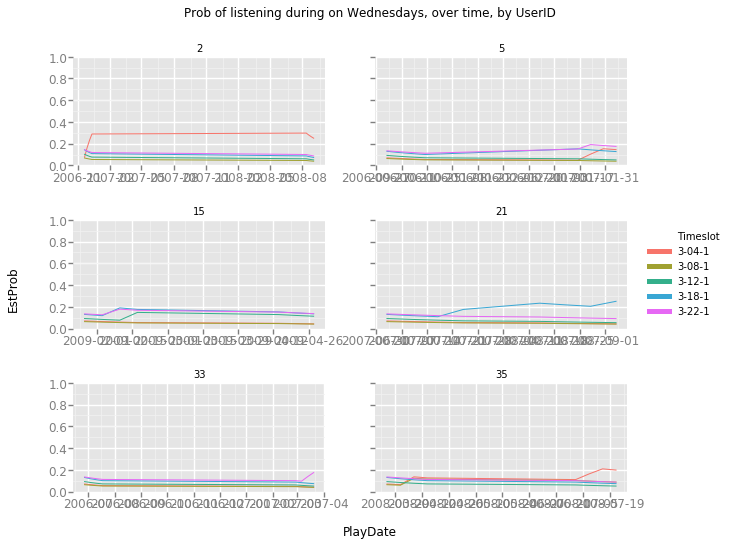

<ggplot: (-9223363244867540981)>

In [19]:
# Select timeslots to plot
t=['3-04-1','3-08-1','3-12-1','3-18-1','3-22-1']
users=[2,5,15,21,35,33]
df=testDf[(testDf.Timeslot.isin(t) & testDf.UserID.isin(users))]
ggplot(df, aes(x='PlayDate', y='EstProb',color='Timeslot')) + geom_line()  + scale_y_continuous(limits=(0,1)) + facet_wrap("UserID",scales="free_x") + ggtitle("Prob of listening during on Wednesdays, over time, by UserID") 


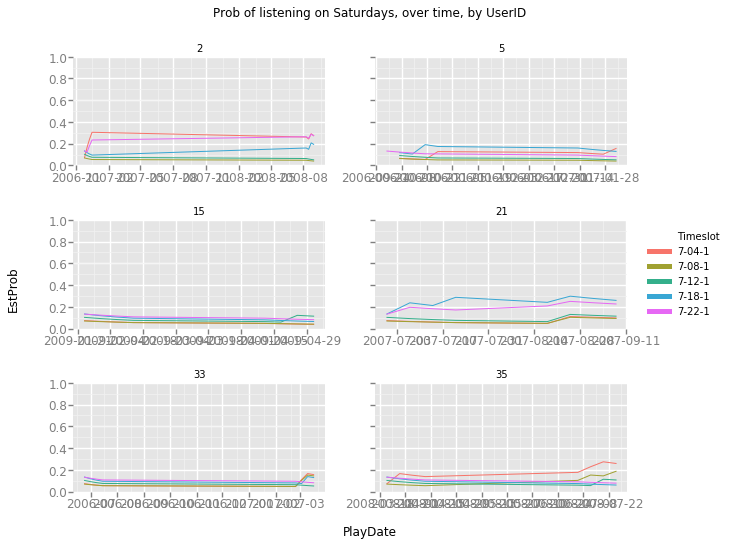

<ggplot: (8791992485622)>

In [20]:
# Select timeslots to plot
t=['7-04-1','7-08-1','7-12-1','7-18-1','7-22-1']
users=[2,5,15,21,35,33]
df=testDf[(testDf.Timeslot.isin(t) & testDf.UserID.isin(users))]
ggplot(df, aes(x='PlayDate', y='EstProb',color='Timeslot')) + geom_line() + scale_y_continuous(limits=(0,1)) + facet_wrap("UserID",scales="free_x") + ggtitle("Prob of listening on Saturdays, over time, by UserID") 


The above charts show that the Beta model adapts to persons preference over a couple of months, provided they are regular listeners. 

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Decide optimal threshold</div>

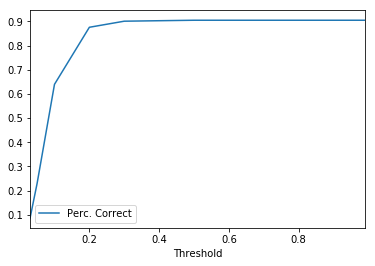

In [21]:
res = pd.DataFrame()
for user in testDf.UserID.unique():
    tmp=evaluateThreshold(testDf[(testDf.UserID == user)],[0.03,0.05,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.99])
    res= res.append(tmp)

res.groupby(['Threshold']).mean().plot()

This is not a good way of analyzing threshold as the highest % is when all the non=plays are guessed correctly at the expense of the plays. Instead we use the following chart:

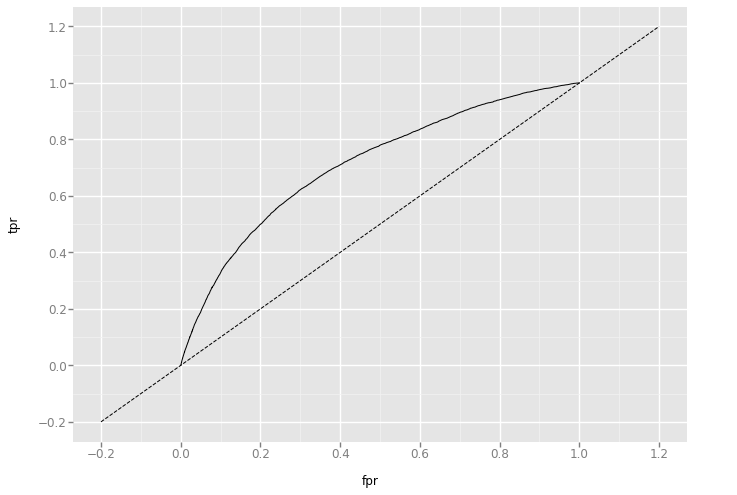

<ggplot: (8791987232839)>

In [22]:
from sklearn import metrics
import pandas as pd
from ggplot import *

actuals=testDf['PlayCount']
preds=(testDf['EstProb'])
fpr, tpr, thresholds = metrics.roc_curve(actuals, preds)

rocRes = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(rocRes, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

0.4 is deemed to be the optimal threshold

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Evaluate accuracy</div>

In [23]:
print(metrics.classification_report((testDf.PlayCount.values >0)*1,(testDf.EstProb.values >= 0.4)*1))
print(metrics.confusion_matrix((testDf.PlayCount.values >0)*1,(testDf.EstProb.values >= 0.4)*1))
print("* Precision = labelled as x / how many were actually x in the ones that were labelled")
print("* Recall = labelled as x / how many were actually x in the dataset")

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     79740
          1       0.19      0.00      0.00      7897

avg / total       0.85      0.91      0.87     87637

[[79715    25]
 [ 7891     6]]
* Precision = labelled as x / how many were actually x in the ones that were labelled
* Recall = labelled as x / how many were actually x in the dataset


<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Assess individualized thresholds</div>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Assess unseen users</div>

In [24]:
testDf2 = getHiddenTestUsers(firstNPerc=0.5)  # Get the first half of everyones history
testDf2.PlayDate.min(),testDf2.PlayDate.max()

(Timestamp('2005-09-15 00:00:00'), Timestamp('2008-07-21 00:00:00'))

In [27]:
# Evaluate - remember the test periods here are much more than what we had in the random period sampling from train users
testDf2=CalcProb(testDf2)
print(metrics.classification_report((testDf2.PlayCount.values >0)*1,(testDf2.EstProb.values >= 0.4)*1))
print(metrics.confusion_matrix((testDf2.PlayCount.values >0)*1,(testDf2.EstProb.values >= 0.4)*1))
print("* Precision = labelled as x / how many were actually x in the ones that were labelled")
print("* Recall = labelled as x / how many were actually x in the dataset")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


             precision    recall  f1-score   support

          0       0.91      0.98      0.94    167893
          1       0.41      0.13      0.19     18304

avg / total       0.86      0.90      0.87    186197

[[164456   3437]
 [ 15958   2346]]
* Precision = labelled as x / how many were actually x in the ones that were labelled
* Recall = labelled as x / how many were actually x in the dataset
